In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [43]:
model = InceptionV3(weights='imagenet')

In [44]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [45]:
image_path = 'Images/newfoundland_126.jpg'  # Replace with your image path
img = preprocess_image(image_path)

In [46]:
img = img.astype(np.uint8)

In [47]:
preds = model.predict(img)
predicted_class = np.argmax(preds[0])
predicted_label = decode_predictions(preds)[0][0][1]


1/1 [==============================] - 1s 1s/step


In [48]:
class_idx = predicted_class

In [49]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [50]:
last_conv_layer_name = 'conv2d_190'

In [51]:
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

In [52]:
with tf.GradientTape() as tape:
    conv_output, preds = grad_model(img)
    loss = preds[:, class_idx]

In [53]:
grads = tape.gradient(loss, conv_output)

In [54]:
weights = tf.reduce_mean(grads, axis=(0, 1, 2))

In [55]:
cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

In [57]:
h, w = img.shape[1], img.shape[2]
cam = tf.image.resize(cam, (h, w))
cam = tf.maximum(cam, 0)  # Apply ReLU to eliminate negative values

In [58]:
cam_max = tf.reduce_max(cam)
if cam_max != 0:
    cam = cam / cam_max

In [59]:
cam = cam[0].numpy()

In [ ]:
import cv2

In [97]:
heatmap = cv2.resize(cam, (img.shape[2], img.shape[1]))

In [98]:
heatmap_jet = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

In [99]:
superimposed_img = heatmap_jet * 0.4 + (img[0] * 255).astype(np.uint8)

In [109]:
def guided_backpropagation(img):
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        class_output = preds[:, class_idx]
    grads = tape.gradient(class_output, img)
    guided_grads = tf.where(grads > 0, grads, tf.zeros_like(grads))
    return guided_grads


In [ ]:
guided_grads = guided_backpropagation(img)

In [ ]:
guided_grads_np = tf.make_ndarray(guided_grads)

In [ ]:
combined_img = superimposed_img.copy()
combined_img[:, :, 0] = np.maximum(superimposed_img[:, :, 0], saliency_map)

In [86]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

In [87]:
plt.figure(figsize=(15, 5 * len(thresholds)))

<Figure size 1500x2500 with 0 Axes>

<Figure size 1500x2500 with 0 Axes>

In [88]:
for i, threshold in enumerate(thresholds):
    # Create a binary mask based on the threshold
    binary_mask = (cam > threshold).astype(np.uint8)

In [90]:
import cv2

In [91]:
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [92]:
img_with_contours = (img[0] * 255).astype(np.uint8).copy()

In [93]:
 cv2.drawContours(img_with_contours, contours, -1, (0, 0, 255), 2)  # Red color for contours

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Text(0.5, 1.0, 'Contours (Threshold = 0.5)')

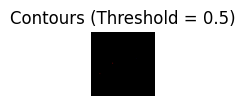

In [94]:
plt.subplot(len(thresholds), 1, i + 1)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Contours (Threshold = {threshold})')

In [95]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [60]:
import cv2

In [61]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

In [67]:
original_img = cv2.imread(image_path)

In [68]:
heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

In [69]:
superimposed_img = heatmap * 0.4 + original_img

In [71]:
superimposed_img = np.clip(superimposed_img, 0, 255)

In [72]:
superimposed_img = superimposed_img.astype(np.uint8)

In [ ]:
cv2.imwrite('grad_cam.jpg', superimposed_img)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Grad-CAM for {predicted_label}')
plt.show()

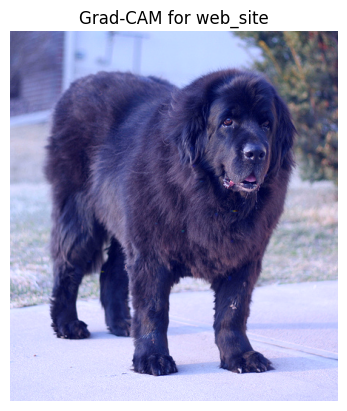

In [73]:
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Grad-CAM for {predicted_label}')
plt.show()

In [82]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0.5, 1.0, 'Original Image')

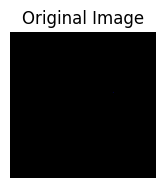

In [83]:
plt.subplot(131)
plt.imshow(cv2.cvtColor((img[0] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

Text(0.5, 1.0, 'Heatmap')

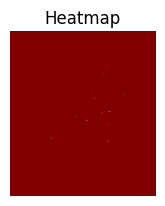

In [84]:
plt.subplot(132)
plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.title('Heatmap')

Text(0.5, 1.0, 'Grad-CAM for web_site')

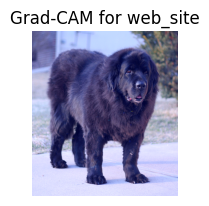

In [85]:
plt.subplot(133)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Grad-CAM for {predicted_label}')

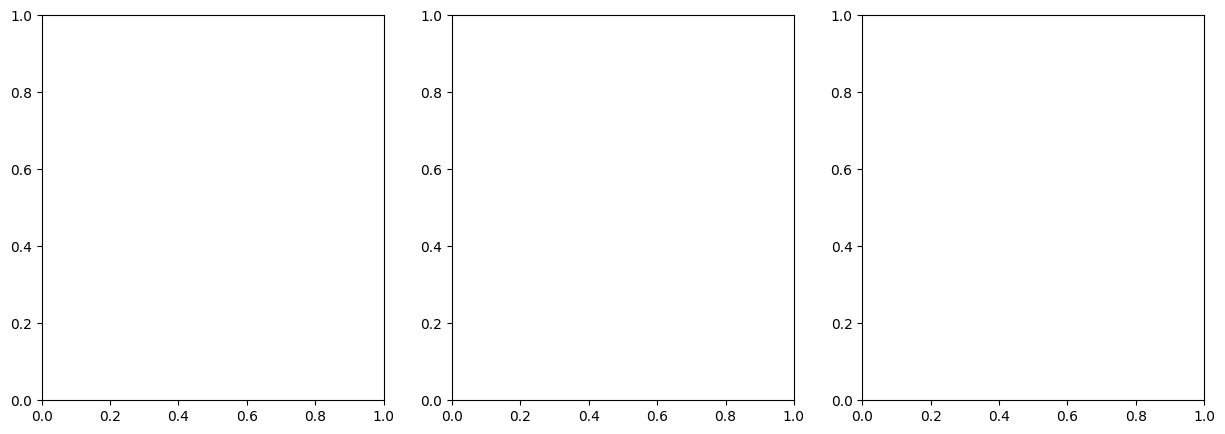

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

In [76]:
axes[0].imshow(cv2.cvtColor((img[0] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Original Image')


Text(0.5, 1.0, 'Original Image')

In [81]:
axes[1].imshow(heatmap, cmap='jet')
axes[1].axis('off')
axes[1].set_title('Heatmap')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [80]:
axes[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axes[2].axis('off')
axes[2].set_title(f'Grad-CAM for {predicted_label}')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [79]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>